<a href="https://colab.research.google.com/github/olgasherbiena/KPI/blob/main/lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Завдання щодо машинного перекладу на базі рекурентних мереж.
Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import os
import requests

In [26]:
input_texts = []  #українська
target_texts = [] #англійська

with open("ukr.txt", "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

# Обробляємо кожен рядок
for line in lines[:10000]:
    parts = line.split("\t")
    if len(parts) >= 2:
        eng_sent = parts[0]
        ukr_sent = parts[1]

        # НАПРЯМОК: ENG -> UKR
        input_texts.append(eng_sent)          # Вхід: Англійська
        target_texts.append("\t" + ukr_sent + "\n")

# 4. Перевірка результату
print(f"Завантажено {len(input_texts)} пар речень.")

Завантажено 10000 пар речень.


In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

# --- НАЛАШТУВАННЯ ---
BATCH_SIZE = 64
EPOCHS = 50
LATENT_DIM = 256

# 1. Токенізація ВХОДУ (Англійська)
print("Обробка Англійської...")
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
input_word_index = input_tokenizer.word_index
max_encoder_seq_length = max([len(x) for x in input_sequences])
num_encoder_tokens = len(input_word_index) + 1

# 2. Токенізація ВИХОДУ (Українська)
print("Обробка Української...")
target_tokenizer = Tokenizer(filters='') # Лишаємо спецсимволи
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
target_word_index = target_tokenizer.word_index
max_decoder_seq_length = max([len(x) for x in target_sequences])
num_decoder_tokens = len(target_word_index) + 1

# 3. Підготовка матриць
print("Створення матриць...")
encoder_input_data = pad_sequences(input_sequences, maxlen=max_encoder_seq_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_decoder_seq_length, padding='post')

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, target_seq in enumerate(target_sequences):
    for t, char_index in enumerate(target_seq):
        if t > 0:
            decoder_target_data[i, t - 1, char_index] = 1.0

# 4. Створення моделі
print("Архітектура LSTM...")
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(num_encoder_tokens, LATENT_DIM, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(LATENT_DIM, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, LATENT_DIM, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Старт навчання
print("Починаємо навчання (50 епох)...")
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.2)

Обробка Англійської...
Обробка Української...
Створення матриць...
Архітектура LSTM...
Починаємо навчання (50 епох)...
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.0043 - loss: 5.2443 - val_accuracy: 0.0069 - val_loss: 5.0533
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0047 - loss: 4.7139 - val_accuracy: 0.0069 - val_loss: 4.9223
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.0053 - loss: 4.6103 - val_accuracy: 0.0069 - val_loss: 4.9197
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0051 - loss: 4.5629 - val_accuracy: 0.0073 - val_loss: 4.9101
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0059 - loss: 4.5428 - val_accuracy: 0.0064 - val_loss: 4.9080
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.0057 - loss: 4.5337 - val_accuracy: 0.0065 - val_loss: 4.8955
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0062 - loss: 4.5255 - val_accuracy: 0.00

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests, zipfile, os

def decode_sequence(input_text):
    seq = input_tokenizer.texts_to_sequences([input_text])
    seq = pad_sequences(seq, maxlen=max_enc_len, padding='post')
    states_value = enc_model.predict(seq, verbose=0)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['\t']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = dec_model.predict([target_seq] + states_value, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0: break
        sampled_word = reverse_target_word_index[sampled_token_index]

        if sampled_word == '\n' or len(decoded_sentence) > 100:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence.strip()

print("\n РЕЗУЛЬТАТИ (ENG -> UKR):")
print("-" * 50)
for eng, _ in demo_pairs:
    # Чистка вхідного тексту
    clean_line = eng.lower().replace(".", "").replace("?", "")
    trans = decode_sequence(clean_line)
    print(f"EN: {eng:<25} | UA: {trans}")

Навчання (30 епох)...
Навчання завершено!

 РЕЗУЛЬТАТИ (ENG -> UKR):
--------------------------------------------------
EN: I go home                 | UA: я йду додому
EN: He is my brother          | UA: він мій брат
EN: She loves him             | UA: вона любить його
EN: Where is the money        | UA: де гроші
EN: I do not want to sleep    | UA: я не хочу спати
EN: It is very cold today     | UA: сьогодні дуже холодно
EN: Open the door             | UA: відкрий двері
EN: Who are you               | UA: хто ти


In [40]:
# --- ТЕСТУВАННЯ (Просто перевіряємо, що модель думає зараз) ---

simple_sentences = [
    "My name is Tom.",
    "I live in London.",
    "London is a big city.",
    "I have a dog and a cat.",
    "My family is very happy.",
    "I go to school every day.",
    "I am happy.",           # Я щасливий
    "He is my brother.",     # Він мій брат
    "She has a cat.",        # У неї є кіт (або "Вона має кота")
    "This is my house.",     # Це мій дім
    "We go home.",           # Ми йдемо додому
    "It is very cold.",      # Дуже холодно
    "I love you.",           # Я тебе люблю
    "the door."         # Відкрий двері
]

print(f"{'INPUT (EN)':<30} | {'OUTPUT (UA)':<30}")
print("-" * 65)

for line in simple_sentences:
    # Очистка тексту (на всяк випадок)
    clean_line = line.lower().replace(".", "").replace("?", "")
    translation = decode_sequence(clean_line)
    print(f"{line:<30} | {translation:<30}")
print("-" * 65)

INPUT (EN)                     | OUTPUT (UA)                   
-----------------------------------------------------------------
My name is Tom.                | зроби це зараз.               
I live in London.              | я почуваюся тома.             
London is a big city.          | в проблем.                    
I have a dog and a cat.        | я це зробив.                  
My family is very happy.       | а зараз і і гаразд.           
I go to school every day.      | я це зробив.                  
I am happy.                    | я не знаю.                    
He is my brother.              | він мій брат                  
She has a cat.                 | вона дуже холодно             
This is my house.              | це це порядку.                
We go home.                    | ми можемо спробувати.         
It is very cold.               | сьогодні дуже холодно         
I love you.                    | я тебе ненавиджу.             
the door.                      | відкр

# **Завдання щодо генерації зображень**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kostastokis/simpsons-faces")

print("Path to dataset files:", path)

100%|██████████| 442M/442M [00:02<00:00, 155MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kostastokis/simpsons-faces/versions/1


Found 19754 files.


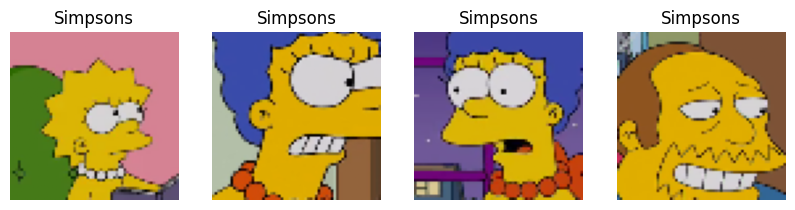

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    label_mode=None,       # Без підписів
    image_size=(64, 64),   # Стискаємо до 64x64
    batch_size=32,         # Пачки по 32 картинки
    shuffle=True           # Перемішуємо
)

dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

for batch in dataset.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        img = (batch[i] + 1) / 2
        plt.imshow(img.numpy())
        plt.axis("off")
        plt.title("Simpsons")
    plt.show()

Знайдено зображень: 19754
Epoch 1/25 | D Loss: 0.3305 | G Loss: 3.7864
Epoch 2/25 | D Loss: 0.3961 | G Loss: 3.0399
Epoch 3/25 | D Loss: 0.5127 | G Loss: 2.7736
Epoch 4/25 | D Loss: 0.4395 | G Loss: 2.8597
Epoch 5/25 | D Loss: 0.4585 | G Loss: 2.8838
Epoch 6/25 | D Loss: 0.4669 | G Loss: 2.8580
Epoch 7/25 | D Loss: 0.3960 | G Loss: 3.0676
Epoch 8/25 | D Loss: 0.4062 | G Loss: 3.0800
Epoch 9/25 | D Loss: 0.4293 | G Loss: 3.0898
Epoch 10/25 | D Loss: 0.4691 | G Loss: 3.0288
Epoch 11/25 | D Loss: 0.3749 | G Loss: 3.1230
Epoch 12/25 | D Loss: 0.3739 | G Loss: 3.1853
Epoch 13/25 | D Loss: 0.4835 | G Loss: 3.0940
Epoch 14/25 | D Loss: 0.3551 | G Loss: 3.2205
Epoch 15/25 | D Loss: 0.3861 | G Loss: 3.2332
Epoch 16/25 | D Loss: 0.2937 | G Loss: 3.4265
Epoch 17/25 | D Loss: 0.3540 | G Loss: 3.3729
Epoch 18/25 | D Loss: 0.4085 | G Loss: 3.3110
Epoch 19/25 | D Loss: 0.4432 | G Loss: 3.1765
Epoch 20/25 | D Loss: 0.2662 | G Loss: 3.5416
Epoch 21/25 | D Loss: 0.4389 | G Loss: 3.1851
Epoch 22/25 | D L

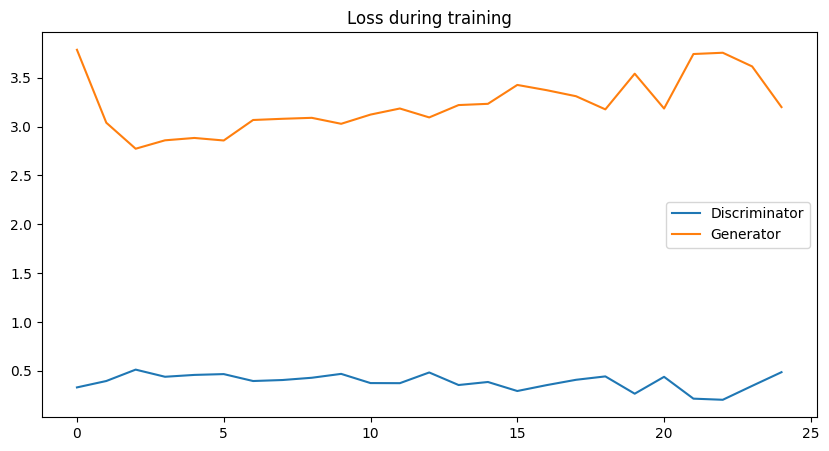

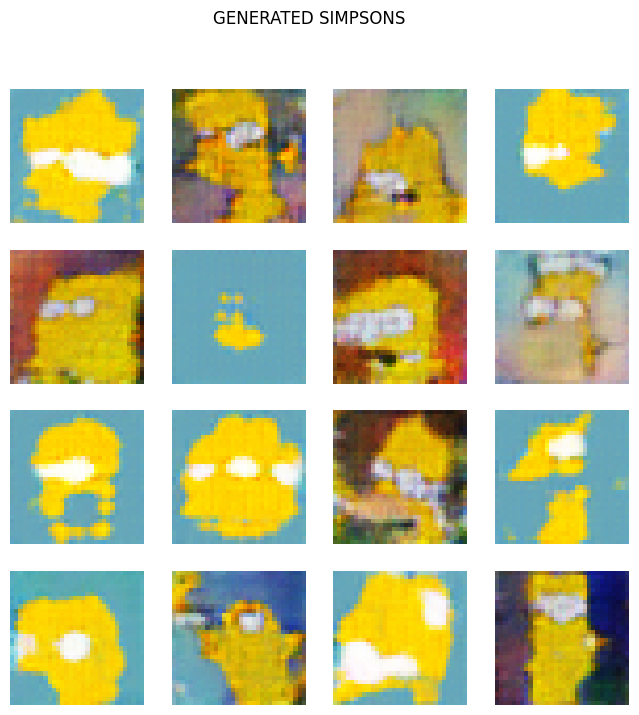

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
image_size = 32
latent_dim = 100
lr = 0.0002
beta1 = 0.5

# --- 2. ПІДГОТОВКА ДАНИХ (SIMPSONS) ---
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Шлях до папки, яку ви отримали раніше
dataset_path = "/root/.cache/kagglehub/datasets/kostastokis/simpsons-faces/versions/1"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
print(f"Знайдено зображень: {len(dataset)}")
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 4, 4)
        x = self.main(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.main(x)
        return x.view(-1, 1).squeeze(1)

# --- 4. ІНІЦІАЛІЗАЦІЯ ---
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.BCELoss()

# --- 5. НАВЧАННЯ ---
num_epochs = 25
losses_g = []
losses_d = []
for epoch in range(num_epochs):
    total_loss_d = 0
    total_loss_g = 0
    batch_count = 0

    for real_images, _ in train_loader:
        real_images = real_images.to(device)
        batch_size_real = real_images.size(0)
        optimizer_d.zero_grad()
        real_labels = torch.ones(batch_size_real, device=device)
        fake_labels = torch.zeros(batch_size_real, device=device)

        d_real_output = discriminator(real_images)
        loss_d_real = criterion(d_real_output, real_labels)

        z = torch.randn(batch_size_real, latent_dim, device=device)
        fake_images = generator(z)
        d_fake_output = discriminator(fake_images.detach())
        loss_d_fake = criterion(d_fake_output, fake_labels)

        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optimizer_d.step()
        optimizer_g.zero_grad()
        d_fake_output = discriminator(fake_images)
        loss_g = criterion(d_fake_output, real_labels)
        loss_g.backward()
        optimizer_g.step()

        total_loss_d += loss_d.item()
        total_loss_g += loss_g.item()
        batch_count += 1

    avg_loss_d = total_loss_d / batch_count
    avg_loss_g = total_loss_g / batch_count
    losses_d.append(avg_loss_d)
    losses_g.append(avg_loss_g)

    print(f"Epoch {epoch+1}/{num_epochs} | D Loss: {avg_loss_d:.4f} | G Loss: {avg_loss_g:.4f}")

# Графік Loss
plt.figure(figsize=(10, 5))
plt.plot(losses_d, label='Discriminator')
plt.plot(losses_g, label='Generator')
plt.title('Loss during training')
plt.legend()
plt.show()

# Генерація картинок
def denormalize(img):
    return (img * 0.5 + 0.5).clamp(0, 1)
generator.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)
    fake_images = generator(z)
    fake_images = denormalize(fake_images).cpu()

    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake_images[i].permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.suptitle('GENERATED SIMPSONS')
    plt.show()